# Lane predictions

Implementing common computer vision techniques to find the lane lines from a dash camera.

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is of type: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


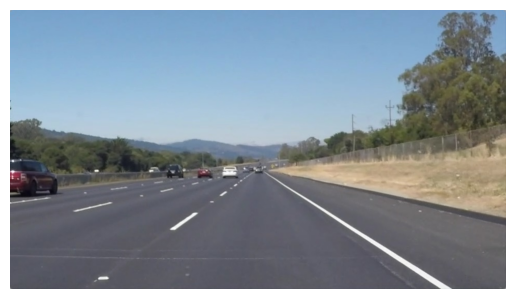

In [2]:
image = mpimg.imread('data/test_images/solidWhiteRight.jpg')
print('This image is of type:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

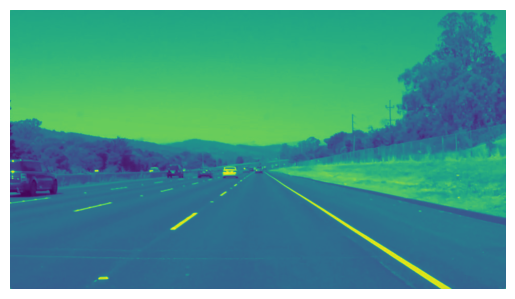

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_img = grayscale(image)
plt.imshow(gray_img)
plt.axis('off')
plt.show()

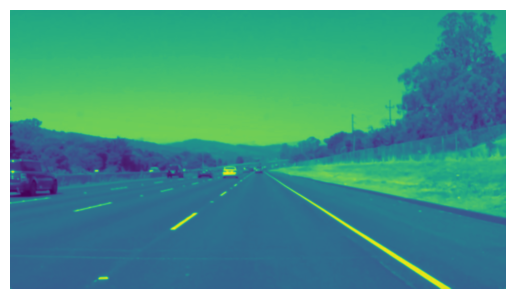

In [4]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
gauss_img = gaussian_blur(gray_img, 5)
plt.imshow(gauss_img)
plt.axis('off')
plt.show()

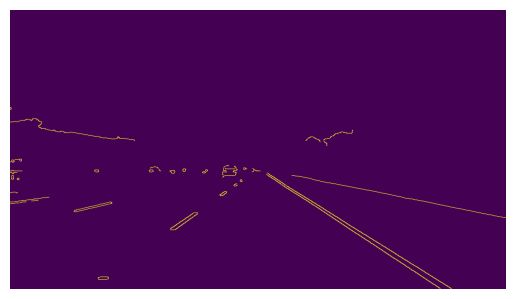

In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
    
canny_img = canny(gauss_img, 150, 250)
plt.imshow(canny_img)
plt.axis('off')
plt.show()

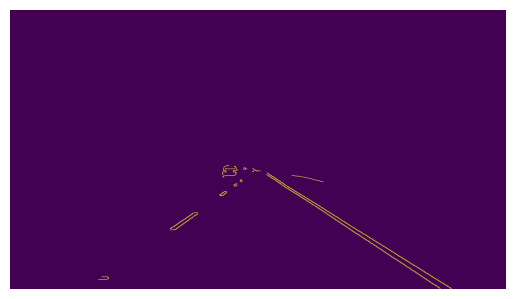

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_vertic = np.array([[150, canny_img.shape[0]], [450, canny_img.shape[0]*0.5],
                          [500, canny_img.shape[0]*0.5], [canny_img.shape[1], canny_img.shape[0]]], np.int32)
roi_img = region_of_interest(canny_img, [roi_vertic])
plt.imshow(roi_img)
plt.axis('off')
plt.show()

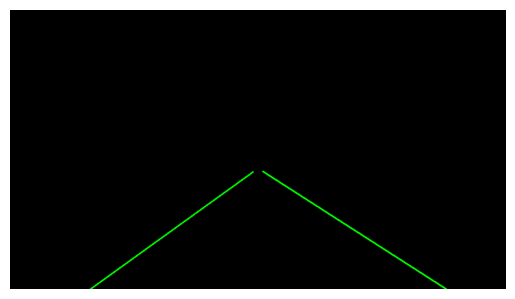

In [7]:
def draw_lines(img, lines, color=[0, 255, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    k_left = []
    b_left = []
    k_right = []
    b_right = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        k = (x2 - x1) / (y2 - y1)
        b = x1 - k * y1
        if k < 0 and k > -3 and b < 1000:
            k_left.append(k)
            b_left.append(b)
        elif k > 0 and k < 2 and b > -100:
            k_right.append(k)
            b_right.append(b)

    if k_left == []:
        k_left = -1.4
    if b_left == []:
        b_left = 1250
    if k_right == []:
        k_right = 1.7
    if b_right == []:
        b_right = -50
    # mean value of slope and bias
    k_left = np.array(k_left).mean()
    b_left = np.array(b_left).mean()
    k_right = np.array(k_right).mean()
    b_right = np.array(b_right).mean()

    try:
        y1_left = img.shape[1]
        x1_left = int((y1_left * k_left + b_left))
        x2_left = int(img.shape[1]*0.49)
        y2_left = int((x2_left - b_left) / k_left)
        cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)

        y1_right = img.shape[1]
        x1_right = int((y1_right * k_right + b_right))
        x2_right = int(img.shape[1]*0.51)
        y2_right = int((x2_right - b_right) / k_right)
        cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
    except:
        pass

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

detect_line = hough_lines(roi_img, 1, np.pi/180, 40, 1, 10)
plt.imshow(detect_line)
plt.axis('off')
plt.show()

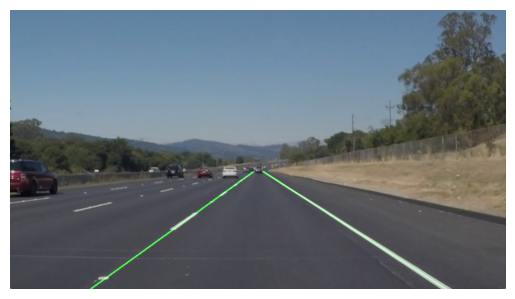

In [8]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
    
wi = weighted_img(detect_line, image)
plt.imshow(wi)
plt.axis('off')
plt.show()

In [9]:
def process_image(image):
    gray_img = grayscale(image)
    gauss_img = gaussian_blur(gray_img, 5)
    canny_img = canny(gauss_img, 150, 250)
    roi_vertic = np.array([[150, canny_img.shape[0]], [450, canny_img.shape[0]*0.5],
                          [500, canny_img.shape[0]*0.5], [canny_img.shape[1], canny_img.shape[0]]], np.int32)
    roi_img = region_of_interest(canny_img, [roi_vertic])
    detect_line = hough_lines(roi_img, 1, np.pi/180, 40, 1, 10)
    result = weighted_img(detect_line, image)
    return result

In [10]:
import os
test_imgs = os.listdir('data/test_images/')
test_imgs

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

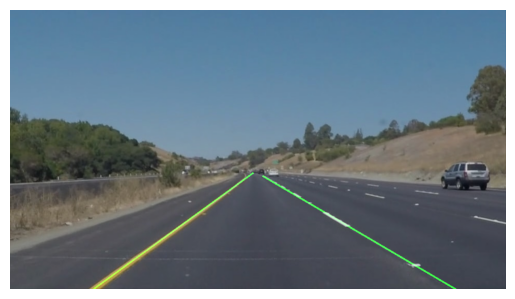

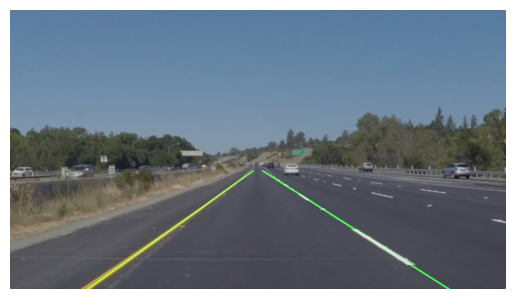

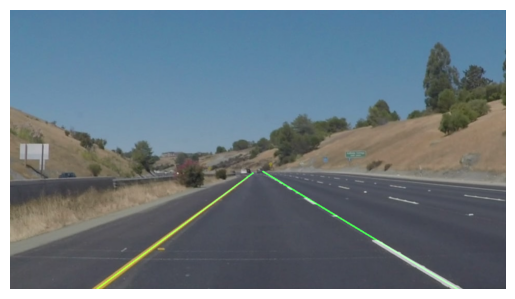

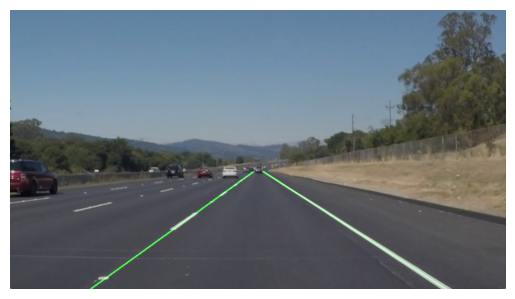

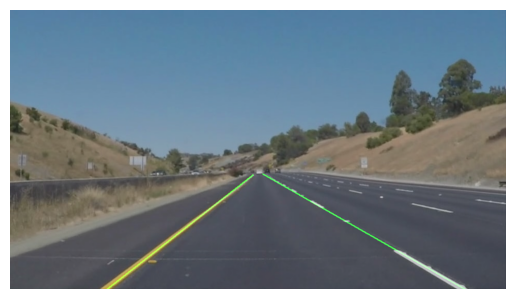

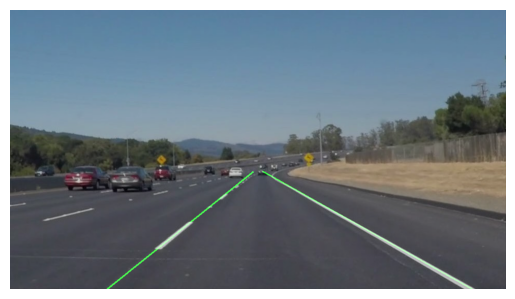

In [11]:
for img_name in test_imgs:
    img = mpimg.imread("data/test_images/" + img_name)
    result = process_image(img)
    plt.imshow(result)
    plt.axis('off')
    plt.show()

In [12]:
from moviepy import VideoFileClip
from IPython.display import Video

In [13]:
test_videos = os.listdir('data/test_videos/')
test_videos

['solidWhiteRight.mp4', 'challenge.mp4', 'solidYellowLeft.mp4']

In [14]:
for video_name in test_videos:
    clip = VideoFileClip("data/test_videos/" + video_name)
    edited_clip = clip.transform(lambda get_frame, t: process_image(get_frame(t)))
    edited_clip.write_videofile("data/test_videos_output/" + video_name, audio=False, fps=clip.fps)
    Video("data/test_videos_output/" + video_name)

MoviePy - Building video data/test_videos_output/solidWhiteRight.mp4.
MoviePy - Writing video data/test_videos_output/solidWhiteRight.mp4



/var/folders/nn/3fpvck9s4n570xz0tg9xg8lc0000gn/T/ipykernel_75701/3942895173.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  k = (x2 - x1) / (y2 - y1)
                                                                         

MoviePy - Done !
MoviePy - video ready data/test_videos_output/solidWhiteRight.mp4
MoviePy - Building video data/test_videos_output/challenge.mp4.
MoviePy - Writing video data/test_videos_output/challenge.mp4



MoviePy - Done !
MoviePy - video ready data/test_videos_output/challenge.mp4
MoviePy - Building video data/test_videos_output/solidYellowLeft.mp4.
MoviePy - Writing video data/test_videos_output/solidYellowLeft.mp4



MoviePy - Done !
MoviePy - video ready data/test_videos_output/solidYellowLeft.mp4


In [15]:
Video("data/test_videos_output/solidWhiteRight.mp4")

In [16]:
Video("data/test_videos_output/solidYellowLeft.mp4")

In [17]:
Video("data/test_videos_output/challenge.mp4")